In [2]:
##FONTE https://github.com/sonisanskar/TextConvoNet/blob/main/TextConvoNet.py
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten,Bidirectional,GRU,LSTM,SpatialDropout1D,Reshape
from tensorflow.keras.layers import Embedding,concatenate
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D,MaxPool2D,MaxPool3D,GlobalAveragePooling2D,Conv3D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import nltk
nltk.download('punkt')

2024-07-01 04:13:47.655120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 04:13:47.655211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 04:13:47.712722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 04:13:47.840041: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 04:13:49.062702: W tensorflow/compiler/tf2

True

In [3]:
import mlflow
import optuna
mlflow.set_tracking_uri("http://localhost:5000")
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)
experiment_id = get_or_create_experiment("FAKE_CNN")
mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='mlflow-artifacts:/283557320663357042', creation_time=1716507639562, experiment_id='283557320663357042', last_update_time=1716507639562, lifecycle_stage='active', name='FAKE_CNN', tags={'mlflow.sharedViewState.7f4d6bce474cd5aa31ae55b20571347b8815f24e8a0cb742cae269d83cfa7446': '{"searchFilter":"","orderByKey":"attributes.start_time","orderByAsc":false,"startTime":"ALL","lifecycleFilter":"Active","datasetsFilter":[],"modelVersionFilter":"All '
                                                                                            'Runs","selectedColumns":["attributes.`Source`","attributes.`Models`","attributes.`Dataset`"],"runsPinned":[],"runsHidden":[],"runsHiddenMode":"FIRST_10_RUNS","compareRunCharts":[{"uuid":"17165424146308eouiehb","type":"BAR","runsCountToCompare":10,"metricSectionId":"1716542414630z4tttoib","deleted":false,"isGenerated":true,"metricKey":"accuracy"},{"uuid":"1716547047359xgfy895a","type":"BAR","runsCountToCompare":10,"metricSectio

In [4]:
def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)
    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [6]:
train = pd.concat([pd.read_csv("fake_train_balanced_indexed.csv")]).reset_index()
# pd.read_csv("fake_train_inc_full_backtranslated_aug_indexed_balanced_v1.csv"), pd.read_csv("fake_train_full_paraphrased_aug_indexed_balanced_llama3.csv")
validate = pd.read_csv("fake_validate_balanced_indexed.csv")

In [7]:
from nltk import word_tokenize
train['tokens']=train['text'].apply(lambda x: word_tokenize(x, language='portuguese'))
validate['tokens']=validate['text'].apply(lambda x: word_tokenize(x, language='portuguese'))
all_training_words = set([word for tokens in list(train["tokens"].values) for word in tokens])


In [8]:
token_dict = {}
with open("skip_s300.txt", "r") as f: #skip_s300.txt cbow_s300.txt
    for line in f:
        token_emb = line.rstrip().split(" ")
        embedding = token_emb[-300:]
        token = " ".join(token_emb[:-300])
        if token in all_training_words:
            token_dict[token] = embedding


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
T_VOCAB = sorted(list(all_training_words))
tokenizer = Tokenizer(num_words=len(T_VOCAB), char_level=False)
tokenizer.fit_on_texts(list(train["tokens"].values))
train_word_index = tokenizer.word_index
len(train_word_index)

207467

In [10]:
train_embedding_weights = np.zeros((len(train_word_index)+1, 300))
for word, i in train_word_index.items():
    embedding_vector = token_dict.get(word)
    if embedding_vector is not None:
        train_embedding_weights[int(i)] = [float(embedding) for embedding in embedding_vector]


In [11]:
import nltk.data 
sent_tokenizer = nltk.data.load('tokenizers/punkt/PY3/portuguese.pickle')

train['sentence_token']=train['text'].apply(lambda x: sent_tokenizer.tokenize(x))
train['train_seq']=train['sentence_token'].apply(lambda x:tokenizer.texts_to_sequences(x))

validate['sentence_token']=validate['text'].apply(lambda x: sent_tokenizer.tokenize(x))
validate['train_seq']=validate['sentence_token'].apply(lambda x:tokenizer.texts_to_sequences(x))




In [12]:
import itertools

train['train_token']= train['train_seq'].apply(lambda x: list(itertools.chain.from_iterable(x)))
validate['train_token']=validate['train_seq'].apply(lambda x: list(itertools.chain.from_iterable(x)))



In [13]:
filter_sizes = [1,2,3,4]
num_filters = 32
embed_size=300
embedding_matrix=train_embedding_weights
max_features=len(train_word_index)+1
#maxlen=6*500#n*m
import tensorflow
from tensorflow.keras.metrics import Precision, Recall, F1Score
def get_model(learning_rate, epsilon, maxlen, n, m):    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    x = Reshape((n, m, 300))(x) #Reshape((n, m, 300))(x)
    #print(x)
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 2),activation='relu')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 3),activation='relu')(x)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 4),activation='relu')(x)
    
    
    conv_4 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 1),activation='relu')(x)
    conv_5 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 2),activation='relu')(x)
    conv_6 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 3),activation='relu')(x)
    
    
    maxpool_0 = MaxPool2D()(conv_0)
    maxpool_0=Flatten()(maxpool_0)
    maxpool_1 = MaxPool2D()(conv_1)
    maxpool_1=Flatten()(maxpool_1)
    maxpool_2 = MaxPool2D()(conv_2)
    maxpool_2 = Flatten()(maxpool_2)
    
    maxpool_4 = MaxPool2D()(conv_4)
    maxpool_4=Flatten()(maxpool_4)
    maxpool_5 = MaxPool2D()(conv_5)
    maxpool_5=Flatten()(maxpool_5)
    maxpool_6 = MaxPool2D()(conv_6)
    maxpool_6=Flatten()(maxpool_6)
    #maxpool_7 = MaxPool2D()(conv_7)
   # maxpool_7=Flatten()(maxpool_7)
    z = concatenate([maxpool_0, maxpool_1,maxpool_2],axis=1)
    w=concatenate([maxpool_4, maxpool_5,maxpool_6],axis=1)    
    #w=concatenate([maxpool_4, maxpool_5,maxpool_6],axis=1)    
    #z = concatenate([maxpool_0, maxpool_1,maxpool_2,maxpool_4, maxpool_5,maxpool_6],axis=1)
    #z = concatenate([maxpool_0, maxpool_1,maxpool_4, maxpool_5],axis=1)
    
    #z = Flatten()(z)
    z=concatenate([w,z],axis=1)
    z=Dense(units=64,activation="relu")(z)
    z = Dropout(0.4)(z)
        
    outp = Dense(1, activation="sigmoid")(z)
    
    model = Model(inputs=inp, outputs=outp)
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate, epsilon = epsilon)
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy', Precision(), Recall(), F1Score()])

    return model

In [12]:
import itertools
import gc
from numba import cuda 
import sys
from multiprocessing import Queue, Process
from optuna.integration import TFKerasPruningCallback
from typing import Optional
from typing import Any
from typing import Dict
import tensorflow as tf
import glob
import os
import json
class HEnconde(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        json.JSONEncoder.default(self, obj)
class TFKerasPruningCallback(TFKerasPruningCallback):
    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        self.best_weights = None
        self.best_acc = 0
    
    def on_epoch_end(self, epoch: int, logs: Optional[Dict[str, Any]] = None) -> None:
        logs = logs or {}
        current_score = logs.get(self._monitor)
        if float(self.best_acc) < float(current_score):
            self.best_acc = current_score
            self.best_weights = self.model.get_weights()
        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self._monitor)
            )
            warnings.warn(message)
            return

        # Report current score and epoch to Optuna's trial.
        self._trial.report(float(current_score), step=epoch)

        # Prune trial if needed
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            self.model.stop_training = True
            #raise optuna.TrialPruned(message)
    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
    
def train_model(params, callbacks):
    def pad_split(x):
            x += ((params["maxlen"] - len(x)) if len(x)<params["maxlen"] else 0) * [0]    
            return x[:params["maxlen"]]
    train_cnn = train['train_token'].apply(lambda x: pad_split(x))
    validate_cnn = validate['train_token'].apply(lambda x: pad_split(x))
    tf.keras.utils.set_random_seed(5113)
    model = get_model(params["learning_rate"], params["epsilon"], params["maxlen"], 6, int(params["maxlen"]/6))
    history=model.fit(list(train_cnn.values), [float(x) for x in train["misinformation"].values],validation_data=(list(validate_cnn.values), [float(x) for x in validate["misinformation"].values]), epochs=params["epochs"],batch_size=params["batch_size"],verbose=0,callbacks = callbacks,)
    #metrics=model.evaluate(list(validate_cnn.values), [float(x) for x in validate["misinformation"].values], verbose=0)
    best_acc_i = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
    metrics = []
    for metric_name in model.metrics_names:
        metrics.append(history.history["val_" + metric_name][best_acc_i])
    for best_m in glob.glob("best_cnn_*.h5"):
        if float(best_m[:-3].replace("best_cnn_", "")) < float(history.history['val_accuracy'][best_acc_i]):
            model.save_weights(f"best_cnn_{str(history.history['val_accuracy'][best_acc_i])}.h5")
            os.remove(best_m)
            with open(f"best_cnn_history.json", "w") as f:
                f.write(json.dumps(dict(history.history), indent=4, cls=HEnconde))
    return [best_acc_i, zip(model.metrics_names, metrics)]

#https://stackoverflow.com/questions/39758094/clearing-tensorflow-gpu-memory-after-model-execution
def process_run(func, params, callbacks):
    def wrapper_func(queue, params, callbacks):
        try:
            result = func(params, callbacks)
            error = None
        except Exception:
            result = None
            ex_type, ex_value, tb = sys.exc_info()
            error = ex_type, ex_value
        queue.put((result, error))

    def process(params, callbacks):
        queue = Queue()
        p = Process(target = wrapper_func, args = [queue] + [params] + [callbacks])
        p.start()
        result, error = queue.get()
        p.join()
        return result, error  

    result, error = process(params, callbacks)
    return result, error


def objective(trial, study):
    # Define hyperparameters
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3),
        "epsilon": trial.suggest_float("epsilon", 1e-8, 1e-5),
        "maxlen": trial.suggest_int("maxlen", 600, 3000, step=600),
        "epochs": 20, #trial.suggest_int("epochs", 2, 12, step=2)
        "batch_size":trial.suggest_int("batch_size", 8, 64, step=8)
    }
    callbacks = [TFKerasPruningCallback(trial, "val_accuracy")]
    #TFKerasPruningCallback(trial, "val_accuracy")
    #tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=0, mode="max"), 
    with mlflow.start_run(nested=True, run_name=f"CNN_MODEL_NO_AUG_SKIP_lr_{params['learning_rate']}_eps_{params['epsilon']}_maxlen_{params['maxlen']}_epochs_{params['epochs']}_bs_{params['batch_size']}"):
        metrics, error = process_run(train_model, params=params, callbacks=callbacks)
        #metrics = train_model(params, callbacks)
        # Log to MLflow
        print(error)
        params["epochs"] = metrics[0] + 1
        mlflow.log_params(params)
        metrics = list(metrics[1])
        metrics = dict(metrics)
        metrics["f1_score"] =  2 * (metrics["precision"] * metrics["recall"]) / (metrics["precision"] + metrics["recall"])
        for metric in metrics:
            mlflow.log_metric(metric, metrics[metric])
        print(dict(metrics))
    return metrics["accuracy"]
        #best_acc = []
        #for i in range(params["epochs"]):
        #    best_acc.append(i, trial.intermediate_values[i])
        #best_acc = max(best_acc, key = lambda x: x[1])
        #params["epochs"] = best_acc[0] + 1
        #mlflow.log_params(params)
        #if not metrics and best_acc <= best_value:
        #    print(params, error)
        #    raise optuna.TrialPruned()
        #mlflow.log_metric("accuracy", best_acc)
    #return best_acc
        

In [13]:
with mlflow.start_run(experiment_id=experiment_id, run_name="CNN_MODEL_NO_AUG_SKIP"):
    # Initialize the Optuna study
    pruner = optuna.pruners.HyperbandPruner(min_resource=2, max_resource=20, reduction_factor=3)
    sampler=optuna.samplers.TPESampler(multivariate=True)
    study_name = "CNN_MODEL_NO_AUG_SKIP_V10"  # Unique identifier of the study.
    storage_name = "sqlite:///{}.db".format(study_name)
    study = optuna.create_study(
        direction="maximize",
        pruner=pruner,
        sampler=sampler,
        study_name=study_name,
        storage=storage_name,
        load_if_exists=True
    )

    # Execute the hyperparameter optimization trials.
    # Note the addition of the `champion_callback` inclusion to control our logging
    complete_trials = 0
    while complete_trials < 50:
        study.optimize(lambda x: objective(x, study), n_trials=1, callbacks=[champion_callback])
        complete_trials = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_accuracy", study.best_value)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "FAKE_NEWS",
            "optimizer_engine": "optuna",
            "model_family": "CNN",
            "feature_set_version": 1,
        }
    )

/home/markt/tcc/jupyter/jupyter-ml/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-06-08 13:21:16,860] A new study created in RDB with name: CNN_MODEL_NO_AUG_SKIP_V10
2024-06-08 13:21:18.824874: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 13:21:18.921469: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 13:21:18.921580: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built 

None
{'loss': 0.6402490139007568, 'accuracy': 0.8099762201309204, 'precision': 0.7794432640075684, 'recall': 0.8646080493927002, 'f1_score': 0.8198198129376624}
Initial trial 0 achieved value: 0.8099762201309204


2024-06-08 13:31:56.385230: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 13:31:56.460489: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 13:31:56.460604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 13:31:56.462759: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 13:31:56.462860: I external/local_xla/xla/stream_executor

None
{'loss': 1.632920265197754, 'accuracy': 0.7980997562408447, 'precision': 0.7839366793632507, 'recall': 0.8230403661727905, 'f1_score': 0.8030127542041988}


2024-06-08 13:56:04.590565: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 13:56:04.669560: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 13:56:04.669669: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 13:56:04.672862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 13:56:04.672998: I external/local_xla/xla/stream_executor

None
{'loss': 0.6741845607757568, 'accuracy': 0.8040379881858826, 'precision': 0.772921085357666, 'recall': 0.8610451221466064, 'f1_score': 0.8146067247841036}


2024-06-08 14:05:17.984732: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:05:18.062237: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:05:18.062339: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:05:18.064127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:05:18.064288: I external/local_xla/xla/stream_executor

None
{'loss': 0.652758002281189, 'accuracy': 0.8087885975837708, 'precision': 0.7653061151504517, 'recall': 0.8907363414764404, 'f1_score': 0.8232711261608013}


2024-06-08 14:27:44.386063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:27:44.443496: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:27:44.443598: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:27:44.445443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:27:44.445556: I external/local_xla/xla/stream_executor

None
{'loss': 0.6270310282707214, 'accuracy': 0.7963182926177979, 'precision': 0.7497497200965881, 'recall': 0.8895487189292908, 'f1_score': 0.813688206066773}


2024-06-08 14:32:00.299289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:32:00.380945: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:32:00.381085: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:32:00.383283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:32:00.383391: I external/local_xla/xla/stream_executor

None
{'loss': 0.6341243982315063, 'accuracy': 0.6306413412094116, 'precision': 0.5924369692802429, 'recall': 0.8372921347618103, 'f1_score': 0.6938976248270894}


2024-06-08 14:34:49.452270: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:34:49.529371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:34:49.529475: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:34:49.531578: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:34:49.531686: I external/local_xla/xla/stream_executor

None
{'loss': 0.6623251438140869, 'accuracy': 0.8117577433586121, 'precision': 0.7777777910232544, 'recall': 0.8729215860366821, 'f1_score': 0.8226077168980166}
Trial 6 achieved value: 0.8117577433586121 with  0.2195% improvement


2024-06-08 14:42:44.383064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:42:44.461076: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:42:44.461236: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:42:44.463189: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:42:44.463321: I external/local_xla/xla/stream_executor

None
{'loss': 0.7079646587371826, 'accuracy': 0.8070071339607239, 'precision': 0.7673215866088867, 'recall': 0.8812351822853088, 'f1_score': 0.8203427276578459}


2024-06-08 14:57:11.114350: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:57:11.178980: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:57:11.179089: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:57:11.180921: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 14:57:11.181048: I external/local_xla/xla/stream_executor

None
{'loss': 0.4353448152542114, 'accuracy': 0.8058194518089294, 'precision': 0.7624872326850891, 'recall': 0.8883610367774963, 'f1_score': 0.82062532467413}


2024-06-08 15:07:43.925975: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:07:44.015329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:07:44.015427: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:07:44.017098: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:07:44.017217: I external/local_xla/xla/stream_executor

None
{'loss': 0.44580987095832825, 'accuracy': 0.783847987651825, 'precision': 0.7394789457321167, 'recall': 0.8764845728874207, 'f1_score': 0.8021739110335114}


2024-06-08 15:15:01.144547: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:15:01.203310: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:15:01.203423: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:15:01.205038: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:15:01.205142: I external/local_xla/xla/stream_executor

None
{'loss': 0.5500140190124512, 'accuracy': 0.7363420724868774, 'precision': 0.6721453070640564, 'recall': 0.9228028655052185, 'f1_score': 0.7777777686599481}


2024-06-08 15:18:45.454446: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:18:45.512471: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:18:45.512589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:18:45.514845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:18:45.514976: I external/local_xla/xla/stream_executor

None
{'loss': 0.5108011364936829, 'accuracy': 0.7553443908691406, 'precision': 0.692307710647583, 'recall': 0.91923987865448, 'f1_score': 0.7897959205819779}


2024-06-08 15:21:51.661856: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:21:51.735834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:21:51.735932: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:21:51.738020: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:21:51.738136: I external/local_xla/xla/stream_executor

None
{'loss': 0.4695214629173279, 'accuracy': 0.7701900005340576, 'precision': 0.7124183177947998, 'recall': 0.9061757922172546, 'f1_score': 0.7976999663158031}


2024-06-08 15:24:29.998198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:24:30.057591: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:24:30.057700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:24:30.059561: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:24:30.059691: I external/local_xla/xla/stream_executor

None
{'loss': 0.6795080900192261, 'accuracy': 0.8087885975837708, 'precision': 0.7691511511802673, 'recall': 0.8824228048324585, 'f1_score': 0.8219026628431239}


2024-06-08 15:36:01.137660: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:36:01.214403: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:36:01.214523: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:36:01.216535: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:36:01.216694: I external/local_xla/xla/stream_executor

None
{'loss': 0.8793688416481018, 'accuracy': 0.8105700612068176, 'precision': 0.788313090801239, 'recall': 0.8491686582565308, 'f1_score': 0.8176100527373026}


2024-06-08 15:43:54.505183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:43:54.592726: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:43:54.592867: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:43:54.594980: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:43:54.595245: I external/local_xla/xla/stream_executor

None
{'loss': 0.48973312973976135, 'accuracy': 0.7731591463088989, 'precision': 0.7102376818656921, 'recall': 0.9228028655052185, 'f1_score': 0.8026859701317411}


2024-06-08 15:46:36.585409: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:46:36.657219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:46:36.657346: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:46:36.659219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:46:36.659422: I external/local_xla/xla/stream_executor

None
{'loss': 0.48208898305892944, 'accuracy': 0.7749406099319458, 'precision': 0.7110300660133362, 'recall': 0.9263657927513123, 'f1_score': 0.8045384104848121}


2024-06-08 15:48:14.632939: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:48:14.709823: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:48:14.709927: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:48:14.711924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:48:14.712070: I external/local_xla/xla/stream_executor

None
{'loss': 0.44517165422439575, 'accuracy': 0.7992874383926392, 'precision': 0.7658227682113647, 'recall': 0.8622328042984009, 'f1_score': 0.8111731861984564}


2024-06-08 15:59:46.218620: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:59:46.304373: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:59:46.304485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:59:46.306327: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 15:59:46.306515: I external/local_xla/xla/stream_executor

None
{'loss': 0.5024035573005676, 'accuracy': 0.7927553653717041, 'precision': 0.7363374829292297, 'recall': 0.9121140241622925, 'f1_score': 0.8148541122463537}


2024-06-08 16:01:54.627639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:01:54.692150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:01:54.692265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:01:54.694763: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:01:54.694957: I external/local_xla/xla/stream_executor

None
{'loss': 0.5185354948043823, 'accuracy': 0.7624703049659729, 'precision': 0.7001811861991882, 'recall': 0.9180522561073303, 'f1_score': 0.7944501712408866}


2024-06-08 16:04:35.535821: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:04:35.612919: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:04:35.613033: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:04:35.614835: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:04:35.614976: I external/local_xla/xla/stream_executor

None
{'loss': 0.46847259998321533, 'accuracy': 0.79038006067276, 'precision': 0.7413622736930847, 'recall': 0.8919239640235901, 'f1_score': 0.8097034832722108}


2024-06-08 16:10:25.982908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:10:26.067749: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:10:26.067867: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:10:26.069845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:10:26.070034: I external/local_xla/xla/stream_executor

None
{'loss': 0.5479399561882019, 'accuracy': 0.8099762201309204, 'precision': 0.791946291923523, 'recall': 0.8408551216125488, 'f1_score': 0.815668200781172}


2024-06-08 16:23:13.543495: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:23:13.622844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:23:13.622964: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:23:13.625627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:23:13.625911: I external/local_xla/xla/stream_executor

None
{'loss': 0.5042393207550049, 'accuracy': 0.8147268295288086, 'precision': 0.8110328912734985, 'recall': 0.8206650614738464, 'f1_score': 0.8158205462642235}
Trial 22 achieved value: 0.8147268295288086 with  0.3644% improvement


2024-06-08 16:35:35.503479: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:35:35.593029: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:35:35.593124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:35:35.594951: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:35:35.595059: I external/local_xla/xla/stream_executor

None
{'loss': 0.49417153000831604, 'accuracy': 0.7773159146308899, 'precision': 0.714811384677887, 'recall': 0.9228028655052185, 'f1_score': 0.8055987470831454}


2024-06-08 16:39:45.233499: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:39:45.319417: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:39:45.319546: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:39:45.321782: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:39:45.321973: I external/local_xla/xla/stream_executor

None
{'loss': 0.5814569592475891, 'accuracy': 0.8040379881858826, 'precision': 0.7661122679710388, 'recall': 0.8752968907356262, 'f1_score': 0.8170731624744239}


2024-06-08 16:51:21.773040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:51:21.849426: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:51:21.849532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:51:21.851437: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:51:21.851574: I external/local_xla/xla/stream_executor

None
{'loss': 0.5289791822433472, 'accuracy': 0.7583135366439819, 'precision': 0.6909569501876831, 'recall': 0.9346793293952942, 'f1_score': 0.794548186397653}


2024-06-08 16:53:22.006570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:53:22.094461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:53:22.094596: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:53:22.096844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:53:22.097011: I external/local_xla/xla/stream_executor

None
{'loss': 0.4564042389392853, 'accuracy': 0.7779097557067871, 'precision': 0.729411780834198, 'recall': 0.8836104273796082, 'f1_score': 0.7991407088093807}


2024-06-08 16:56:09.943433: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:56:10.003914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:56:10.004009: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:56:10.005795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 16:56:10.005906: I external/local_xla/xla/stream_executor

None
{'loss': 0.7912984490394592, 'accuracy': 0.8064132928848267, 'precision': 0.780434787273407, 'recall': 0.8527315855026245, 'f1_score': 0.8149829737209769}


2024-06-08 17:08:54.097663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:08:54.182733: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:08:54.182870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:08:54.184956: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:08:54.185121: I external/local_xla/xla/stream_executor

None
{'loss': 0.43673330545425415, 'accuracy': 0.8129453659057617, 'precision': 0.7830290198326111, 'recall': 0.8657957315444946, 'f1_score': 0.8223350389182634}


2024-06-08 17:16:36.221530: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:16:36.313041: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:16:36.313218: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:16:36.316047: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:16:36.316273: I external/local_xla/xla/stream_executor

None
{'loss': 0.5152807235717773, 'accuracy': 0.754156768321991, 'precision': 0.6880491971969604, 'recall': 0.929928719997406, 'f1_score': 0.7909090753897466}


2024-06-08 17:20:30.850178: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:20:30.913173: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:20:30.913320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:20:30.915229: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:20:30.915417: I external/local_xla/xla/stream_executor

None
{'loss': 0.48801738023757935, 'accuracy': 0.7850356101989746, 'precision': 0.741448700428009, 'recall': 0.8752968907356262, 'f1_score': 0.8028322398671335}


2024-06-08 17:24:32.708870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:24:32.769197: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:24:32.769322: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:24:32.785967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:24:32.786130: I external/local_xla/xla/stream_executor

None
{'loss': 0.5040186047554016, 'accuracy': 0.7577196955680847, 'precision': 0.6937500238418579, 'recall': 0.9228028655052185, 'f1_score': 0.7920489507821223}


2024-06-08 17:26:31.398903: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:26:31.481927: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:26:31.482198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:26:31.484555: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:26:31.484802: I external/local_xla/xla/stream_executor

None
{'loss': 0.5147228240966797, 'accuracy': 0.8129453659057617, 'precision': 0.7724922299385071, 'recall': 0.8871734142303467, 'f1_score': 0.825870646306195}


2024-06-08 17:36:22.173342: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:36:22.235652: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:36:22.235785: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:36:22.237861: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:36:22.238059: I external/local_xla/xla/stream_executor

None
{'loss': 0.47670671343803406, 'accuracy': 0.771377682685852, 'precision': 0.7182425856590271, 'recall': 0.8931116461753845, 'f1_score': 0.7961884548513329}


2024-06-08 17:39:42.483640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:39:42.551838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:39:42.552122: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:39:42.554561: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:39:42.555043: I external/local_xla/xla/stream_executor

None
{'loss': 0.5804195404052734, 'accuracy': 0.8105700612068176, 'precision': 0.7802786827087402, 'recall': 0.8646080493927002, 'f1_score': 0.8202816846575484}


2024-06-08 17:49:57.829397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:49:57.913961: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:49:57.914091: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:49:57.916783: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:49:57.917134: I external/local_xla/xla/stream_executor

None
{'loss': 0.7808659672737122, 'accuracy': 0.8076009750366211, 'precision': 0.7778970003128052, 'recall': 0.8610451221466064, 'f1_score': 0.817361892739328}


2024-06-08 17:58:10.385309: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:58:10.447776: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:58:10.447871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:58:10.449906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 17:58:10.450027: I external/local_xla/xla/stream_executor

None
{'loss': 0.5391106009483337, 'accuracy': 0.815914511680603, 'precision': 0.7935982346534729, 'recall': 0.853919267654419, 'f1_score': 0.8226544754733525}
Trial 36 achieved value: 0.815914511680603 with  0.1456% improvement


2024-06-08 18:02:00.259649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:02:00.337526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:02:00.337632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:02:00.339860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:02:00.340125: I external/local_xla/xla/stream_executor

None
{'loss': 0.5263763070106506, 'accuracy': 0.7654394507408142, 'precision': 0.6969162821769714, 'recall': 0.9394299387931824, 'f1_score': 0.8002023189460783}


2024-06-08 18:04:35.986362: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:04:36.062667: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:04:36.062773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:04:36.064624: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:04:36.064868: I external/local_xla/xla/stream_executor

None
{'loss': 0.4261849820613861, 'accuracy': 0.8064132928848267, 'precision': 0.7632653117179871, 'recall': 0.8883610367774963, 'f1_score': 0.8210757406137907}


2024-06-08 18:08:06.261638: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:08:06.321973: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:08:06.322071: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:08:06.323983: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:08:06.324093: I external/local_xla/xla/stream_executor

None
{'loss': 0.5322001576423645, 'accuracy': 0.8087885975837708, 'precision': 0.7844638824462891, 'recall': 0.8515439629554749, 'f1_score': 0.8166287039897474}


2024-06-08 18:11:52.130028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:11:52.201933: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:11:52.202027: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:11:52.203965: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:11:52.204056: I external/local_xla/xla/stream_executor

None
{'loss': 0.44568854570388794, 'accuracy': 0.7808788418769836, 'precision': 0.7263157963752747, 'recall': 0.9014251828193665, 'f1_score': 0.8044515164275238}


2024-06-08 18:15:31.265807: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:15:31.338568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:15:31.338677: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:15:31.340563: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:15:31.340653: I external/local_xla/xla/stream_executor

None
{'loss': 0.5099444389343262, 'accuracy': 0.745843231678009, 'precision': 0.6875, 'recall': 0.9014251828193665, 'f1_score': 0.7800616667031164}


2024-06-08 18:18:02.679367: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:18:02.754657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:18:02.754756: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:18:02.756960: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:18:02.757081: I external/local_xla/xla/stream_executor

None
{'loss': 0.599049985408783, 'accuracy': 0.8070071339607239, 'precision': 0.8002322912216187, 'recall': 0.8182897567749023, 'f1_score': 0.8091602925739924}


2024-06-08 18:24:21.436008: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:24:21.515095: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:24:21.515200: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:24:21.516995: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:24:21.517104: I external/local_xla/xla/stream_executor

None
{'loss': 0.48842501640319824, 'accuracy': 0.764845609664917, 'precision': 0.70802241563797, 'recall': 0.9014251828193665, 'f1_score': 0.7931034673864653}


2024-06-08 18:27:33.072988: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:27:33.155937: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:27:33.156077: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:27:33.158862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:27:33.159484: I external/local_xla/xla/stream_executor

None
{'loss': 0.4588354825973511, 'accuracy': 0.8141329884529114, 'precision': 0.7897042632102966, 'recall': 0.8562945127487183, 'f1_score': 0.8216524060137992}


2024-06-08 18:29:37.689315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:29:37.766200: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:29:37.766304: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:29:37.768370: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:29:37.768474: I external/local_xla/xla/stream_executor

None
{'loss': 0.6008214354515076, 'accuracy': 0.8070071339607239, 'precision': 0.8044758439064026, 'recall': 0.8111639022827148, 'f1_score': 0.8078060302422303}


2024-06-08 18:31:42.359018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:31:42.436555: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:31:42.436653: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:31:42.438493: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:31:42.438607: I external/local_xla/xla/stream_executor

None
{'loss': 0.5260790586471558, 'accuracy': 0.7381235361099243, 'precision': 0.6672226786613464, 'recall': 0.9501187801361084, 'f1_score': 0.7839294467851216}


2024-06-08 18:33:39.687222: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:33:39.762375: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:33:39.762478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:33:39.764267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:33:39.764368: I external/local_xla/xla/stream_executor

None
{'loss': 0.4215407073497772, 'accuracy': 0.8171021342277527, 'precision': 0.7947019934654236, 'recall': 0.8551068902015686, 'f1_score': 0.823798631461814}
Trial 47 achieved value: 0.8171021342277527 with  0.1453% improvement


2024-06-08 18:35:50.441506: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:35:50.514832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:35:50.514930: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:35:50.527108: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:35:50.527247: I external/local_xla/xla/stream_executor

None
{'loss': 0.4835796654224396, 'accuracy': 0.7719715237617493, 'precision': 0.7059352397918701, 'recall': 0.9323040246963501, 'f1_score': 0.8034800282223072}


2024-06-08 18:37:21.728641: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:37:21.789429: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:37:21.789527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:37:21.791487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:37:21.791592: I external/local_xla/xla/stream_executor

None
{'loss': 0.45601433515548706, 'accuracy': 0.820071280002594, 'precision': 0.8181818127632141, 'recall': 0.8230403661727905, 'f1_score': 0.820603898015944}
Trial 49 achieved value: 0.820071280002594 with  0.3621% improvement


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
#early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=4, verbose=1, mode="max")
#filepath = 'fake_model_cnn.h5'

#checkpoint = ModelCheckpoint(filepath,monitor = 'val_accuracy', save_best_only=True, mode='max', save_weights_only=True)
tf.keras.utils.set_random_seed(5113)
callbacks_list = []
def pad_split(x):
        x += ((1200 - len(x)) if len(x)<1200 else 0) * [0]    
        return x[:1200]
train_cnn = train['train_token'].apply(lambda x: pad_split(x))
validate_cnn = validate['train_token'].apply(lambda x: pad_split(x))

import time, datetime
model = get_model(0.0009424649455690445, 2.6200089221648253e-6, 1200, 6, 200)
history=model.fit(list(train_cnn.values), [float(x) for x in train["misinformation"].values],validation_data=(list(validate_cnn.values), [float(x) for x in validate["misinformation"].values]), epochs=3,callbacks=callbacks_list,batch_size=56,verbose=1)

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
import nltk.data
import itertools
sent_tokenizer = nltk.data.load('tokenizers/punkt/PY3/portuguese.pickle')
class FakeTokenizer:
    def __init__(self, all_training_words, train, maxlen, sent_tokenizer):
        self.sent_tokenizer = sent_tokenizer
        self.T_VOCAB = sorted(list(all_training_words))
        self.tokenizer = Tokenizer(num_words=len(T_VOCAB), char_level=False)
        self.tokenizer.fit_on_texts(list(train["tokens"].values))
        self.maxlen = maxlen
    def pad_split(self, x):
        x += ((self.maxlen - len(x)) if len(x)<self.maxlen else 0) * [0]    
        return x[:self.maxlen]
    def text_tokenizer(self, text):
        tokenized_text = self.sent_tokenizer.tokenize(text)
        tokenized_text = self.tokenizer.texts_to_sequences(tokenized_text)
        tokenized_text = list(itertools.chain.from_iterable(tokenized_text))
        return self.pad_split(tokenized_text)
    

with open('fake_skip_no_aug_tokenizer_cnn.pkl', 'wb') as f:  # open a text file
    pickle.dump(FakeTokenizer(all_training_words, train, 1200, sent_tokenizer), f)
        

In [12]:
model.save_weights('cnn_model_best.h5')


In [14]:
model = get_model(0.0008946368929683414, 6.581594777234862e-06, 600, 6, 100)
model.load_weights('best_cnn_0.820071280002594.h5')

2024-07-01 04:16:49.528661: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 04:16:50.463405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 04:16:50.463533: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 04:16:50.466256: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 04:16:50.466383: I external/local_xla/xla/stream_executor

In [15]:
test = pd.read_csv("fake_test_balanced_indexed.csv")
test

,Unnamed: 0,text,misinformation,index
0,3722,O PT convocou todos os macumbeiros do Brasil e...,1,3722
1,16059,"“Bem, acredito que esteje tudo bem com você, a...",1,16059
2,13247,“Laudo médico rompimento da artéria devido o e...,1,13247
3,11255,… Já está sendo vendida em outros Estados e es...,1,11255
4,15979,Na Argentina ta tudo normal! STF da Argentina ...,1,15979
...,...,...,...,...
1679,6283,￼\n\nGeneral Paulo Chagas alerta Ciro Gomes\n\...,0,6283
1680,6707,moradores da cidade argentina santiago del est...,0,6707
1681,4081,Montes claros parou pra gritar 17.\nÉ só o com...,0,4081
1682,14727,A atriz da Globo teve um vídeo vazado na inter...,0,14727


2024-07-01 04:17:59.280320: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


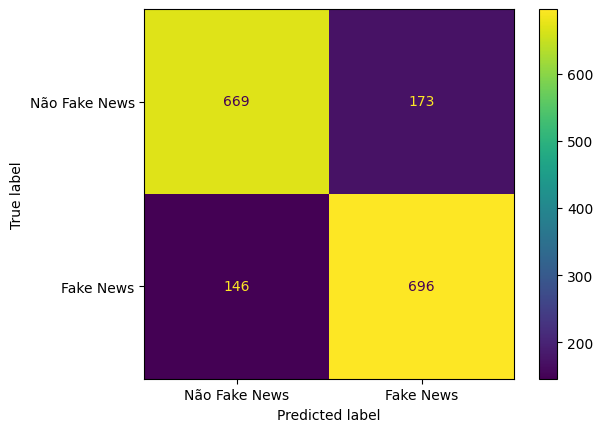

In [19]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from transformers import pipeline
def classifier(text, model, tokenizer):
    return model.predict([tokenizer(text)], verbose=0)
#classifier = pipeline(task="text-classification", model=model, top_k=None, tokenizer=FakeTokenizer(all_training_words, train, 1200).tokenizer)
fake_tokenizer = FakeTokenizer(all_training_words, train, 600, sent_tokenizer)
classify_all = test["text"].apply(lambda x: classifier(x, model, fake_tokenizer.text_tokenizer)).values

pred_labels = []
for classification in classify_all:
  if classification[0] >= 0.5:
    pred_labels.append(1)
  else:
    pred_labels.append(0)

confusion_matrix = metrics.confusion_matrix(test["misinformation"].values, pred_labels)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Não Fake News", "Fake News"])

cm_display.plot()
plt.show()

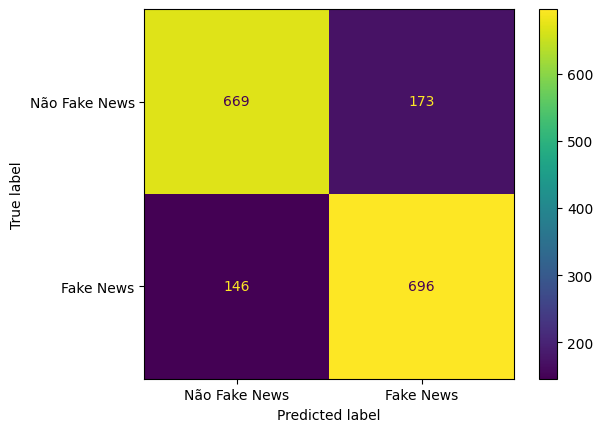

In [29]:
#old_test = pd.read_csv("drive/MyDrive/test_fake.csv")
##classifier = pipeline(task="text-classification", model=model, top_k=None, tokenizer=tokenizer)
#classify_all_old = classifier(list(old_test["text"].values))
#
#pred_labels = []
#for classification in classify_all_old:
#  label0 = 0
#  label1 = 0
#  for label in classification:
#    if label["label"] == "LABEL_0":
#      label0=label["score"]
#    if label["label"] == "LABEL_1":
#      label1=label["score"]
#  if label0 > label1:
#    pred_labels.append(0)
#  else:
#    pred_labels.append(1)

confusion_matrix = metrics.confusion_matrix(test["misinformation"].values, pred_labels)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Não Fake News", "Fake News"])

cm_display.plot()
plt.savefig('cnn_results.png')
plt.show()

In [21]:
from sklearn.metrics import classification_report
target_names = ["0", "1"]
print(classification_report(test["misinformation"].map(lambda x: str(x)).values, [ str(x) for x in pred_labels], target_names=target_names))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       842
           1       0.80      0.83      0.81       842

    accuracy                           0.81      1684
   macro avg       0.81      0.81      0.81      1684
weighted avg       0.81      0.81      0.81      1684



In [22]:
metrics.precision_recall_fscore_support(test["misinformation"].values, pred_labels, average=None, labels=[0, 1])

(array([0.8208589, 0.8009206]),
 array([0.79453682, 0.82660333]),
 array([0.8074834 , 0.81355932]),
 array([842, 842]))

In [23]:
metrics.accuracy_score(test["misinformation"].values, pred_labels, normalize=True)


0.8105700712589073

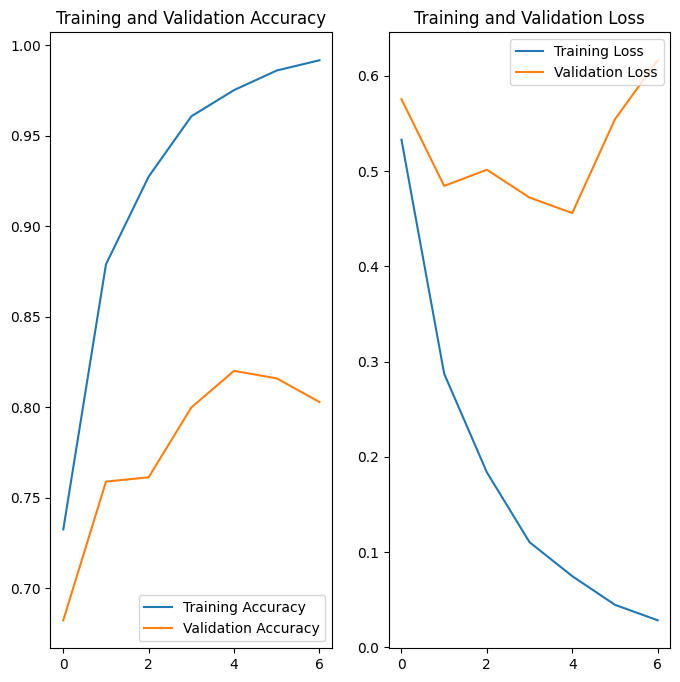

In [28]:
import json
with open("best_cnn_history.json") as f:
    history = json.loads(f.read())
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs_range = range(7)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()